# 2020 P-ADA-wan ADA Project: Milestone 4, Machine Learning Part

This notebook is part of the Fall 2020 EPFL ADA course.

On this part of the notebook, we'll try to extend the Tesco's paper. We will try to create correct Machine Learning algorithms which will link Tesco's grocery data with children obesity, then extract meaningful informations from our results.

## Loading the Dataset

As usual, we will import our libraries and our dataset in our notebook. The data was taken from [The official paper's dataset](https://figshare.com/collections/Tesco_Grocery_1_0/4769354/2)

In [443]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

In [400]:
# Loading the files into DataFrames
obesity = pd.read_csv(Path.cwd() / "data" / "child_obesity_london_ward_2013-2014.csv")
grocery = pd.read_csv(Path.cwd() / "data" / "year_osward_grocery.csv")

In [401]:
# Let's have a closer look at the dataframes
grocery.head(5)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E05000026,449.535137,32.5,166.4,300.0,500.0,1500.0,771.349423,3.716832,125.960833,...,37315,14370.0,7469.0,6901.0,4211.0,9421.0,738.0,29.572999,1.26,11404.761905
1,E05000027,413.130263,32.5,150.0,300.0,500.0,1500.0,626.395178,5.164174,110.664114,...,14474,10845.0,5228.0,5617.0,3205.0,6608.0,1032.0,33.568004,1.36,7974.264706
2,E05000028,407.100472,32.5,160.0,300.0,500.0,1200.0,545.890959,2.710677,121.990710,...,32138,13856.0,6750.0,7106.0,4180.0,8537.0,1139.0,32.032693,1.29,10741.085271
3,E05000029,384.173858,30.0,150.0,250.0,454.0,1500.0,591.837557,4.968373,122.245578,...,16223,10850.0,5300.0,5550.0,3023.0,6251.0,1576.0,36.004793,3.38,3210.059172
4,E05000030,356.882607,30.0,140.0,250.0,450.0,1000.0,465.284180,3.880963,109.959688,...,17522,11348.0,5515.0,5833.0,2747.0,6961.0,1640.0,37.247444,3.45,3289.275362


In [402]:
obesity.head(5)

,area_id,number_reception_measured,number_y6_measured,prevalence_overweight_reception,prevalence_overweight_y6,prevalence_obese_reception,prevalence_obese_y6
0,E05000026,712,441,0.259831461,0.387755102,0.133426966,0.247165533
1,E05000027,592,427,0.224662162,0.402810304,0.099662162,0.259953162
2,E05000028,665,499,0.24962406,0.466933868,0.123308271,0.29258517
3,E05000029,484,362,0.241735537,0.422651934,0.128099174,0.245856354
4,E05000030,446,320,0.257847534,0.378125,0.125560538,0.215625


In [403]:
joined_df = grocery.merge(obesity, how='inner', on='area_id')

In [404]:
print(f"We have {len(grocery.columns)} potentials predictors and {len(obesity.columns)} potential labels, for {len(joined_df)} datapoints")

We have 202 potentials predictors and 7 potential labels, for 544 datapoints


### Choosing the correct columns

As we see with the output of the previous cell, we have a problem. Indeed, we have too many columns for our number of datapoints. With 202 predictors for 544 datapoints, our model will not represent properly the reality.

Hence, we should select the columns that will be meaningful to predict our output. But actually, what's our output ? 

When we read the [Tesco's paper reference](https://figshare.com/articles/dataset/Validation_data_obesity_diabetes_/7796672?backTo=/collections/Tesco_Grocery_1_0/4769354) we see that we have 4 interesting columns, which represent the prevalence of overweight and obese for children of year 6 and children of year 4 and 5.

As the data for the overweight children will be more sparse than the data for the obese children (obese children will be included in the overweight ones -> we will always have a greater value for overweight children than for obese), we'll choose to predict the overweight children. We'll also choose to select the data for year 6 children, as we tend to give more liberty to food consumption's of children when they age.

So our labeled data will be the column "prevalence_overweight_y6".

As we take data from londonese children, we'll follow [the guidelines of the National Health Service](https://www.nhs.uk/conditions/obesity/causes/) to select our predictors. We can note that there are four points that we can extract from the dataset that causes obesity: calories, fat, sugar and alcohol. As children of 6 years old are not likely to drink alcohol, we will focus on the 3 columns _fat_, _sugar_ and _energy_tot_

## First try : follow NHS guidelines on nutrients

In [405]:
data_1 = joined_df[["fat", "sugar", "energy_tot", "prevalence_overweight_y6"]]
data_1.head(5)

,fat,sugar,energy_tot,prevalence_overweight_y6
0,9.488797,10.966213,187.114757,0.387755102
1,9.733634,10.514427,188.638145,0.402810304
2,9.216310,10.690272,186.861792,0.466933868
3,9.700137,12.938606,190.783934,0.422651934
4,9.381808,11.332898,188.136201,0.378125


We have obtained the DataFrame containing the informations we wanted to.

We now have to preprocess our input. To this end, we will remove the NA values from the target, standardize our predictor, and split the original data into a train and a test set.

In [406]:
# Sanitazing NA data. As they are considered as string in the original dataset, we have to remove them as string, then convert it to float.
data_1 = data_1[data_1["prevalence_overweight_y6"] != "na"]

X_1 = data_1[["fat", "sugar", "energy_tot"]]
Y_1 = data_1["prevalence_overweight_y6"].astype(float)

X_1 = (X_1 - np.mean(X_1, axis=0)) / np.std(X_1, axis=0)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, Y_1, test_size=0.3, random_state=0)

## Creating our Machine Learning Models

Now that we have our data prepared, we will now compute different ML algorithms in order to find out the one that perform the best.

In our case, we will use the [R-squared](https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/) to estimate the efficiency of our ML algorithm. To give a quick recap, the R-squared represent the value obtained when comparing the residual sum of squares (SSres) with total sum of squares(SStot). If the model fit the data perfectly, the value obtained will be 1. If we create an average line and present it as our model, the value obtained will be 0. Hence, everything between 0 and 1 means that our model is better than drawing a straight line, and everything below 0 means that our model is worse than an average line (which is not what we want to have).

At the same time, we will get the MSE error, to have a second comparison points

In [407]:
# Linear Regression
def linear_regression(X_train, y_train, X_test, y_test):
    linear_model = LinearRegression()
    linear_model = linear_model.fit(X_train, y_train)
    linear_model_prediction = linear_model.predict(X_test)

    print(f"Mean squared error: {mean_squared_error(y_test, linear_model_prediction):.3f}")
    print(f"R2 score: {r2_score(y_test, linear_model_prediction):.3f}")
    print(f"coefs {linear_model.coef_}")

#Lasso model
def lasso_model(X_train, y_train, X_test, y_test):
    alphas = np.arange(0.1, 10, 0.1)
    best_r2_score_lasso = -99
    mse_score_related_lasso = 0
    best_alpha = 0


    for alpha in alphas:
        lasso_model = linear_model.Ridge(alpha=alpha)
        lasso_model.fit(X_train, y_train)
        lasso_model_prediction = lasso_model.predict(X_test)
        r2 = r2_score(y_test, lasso_model_prediction)
        mse = mean_squared_error(y_test, lasso_model_prediction)
        if r2 > best_r2_score_lasso:
            best_r2_score_lasso = r2
            mse_score_related_lasso = mse
            best_alpha = alpha

    print(f"A lasso model obtain the best r2 score when the lasso alpha is {best_alpha}. The r2 score is {best_r2_score_lasso:.3f} and the related mse score is {mse_score_related_lasso:.3f}")

# Ridge model
def ridge_model(X_train, y_train, X_test, y_test):
    best_r2_score_ridge = -99
    mse_score_related_ridge = 0
    best_alpha = 0


    for alpha in alphas:
        ridge_model = linear_model.Ridge(alpha=alpha)
        ridge_model.fit(X_train, y_train)
        ridge_model_prediction = ridge_model.predict(X_test)
        r2 = r2_score(y_test, ridge_model_prediction)
        mse = mean_squared_error(y_test, ridge_model_prediction)
        if r2 > best_r2_score_ridge:
            best_r2_score_ridge = r2
            mse_score_related_ridge = mse
            best_alpha = alpha

    print(f"A ridge model obtain the best r2 score when the lasso alpha is {best_alpha}. The r2 score is {best_r2_score_ridge:.3f} and the related mse score is {mse_score_related_ridge:.3f}")
    
def svm_model(X_train, y_train, X_test, y_test):
    svm_model = svm.SVR()
    svm_model = svm_model.fit(X_train, y_train)
    svm_model_prediction = svm_model.predict(X_test)

    print(f"SVM: Mean squared error: {mean_squared_error(y_test, svm_model_prediction):.3f}")
    print(f"SVM: R2 score: {r2_score(y_test, svm_model_prediction):.3f}")

    
def tree_model(X_train, y_train, X_test, y_test):
    tree_model = tree.DecisionTreeRegressor()
    tree_model = tree_model.fit(X_train, y_train)
    tree_model_prediction = tree_model.predict(X_test)

    print(f"Decision Tree: Mean squared error: {mean_squared_error(y_test, tree_model_prediction):.3f}")
    print(f"Decision Tree: R2 score: {r2_score(y_test, tree_model_prediction):.3f}")

def GBR_model(X_train, y_train, X_test, y_test):
    GBR_model = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    GBR_model = GBR_model.fit(X_train, y_train)
    GBR_model_prediction = GBR_model.predict(X_test)

    print(f"Gradient Boosting Regressor: Mean squared error: {mean_squared_error(y_test, GBR_model_prediction):.3f}")
    print(f"Gradient Boosting Regressor::R2 score: {r2_score(y_test, GBR_model_prediction):.3f}")
    
def ADA_model(X_train, y_train, X_test, y_test):
    ADA_model = AdaBoostRegressor(n_estimators=10)
    ADA_model = ADA_model.fit(X_train, y_train)
    ADA_model_prediction = ADA_model.predict(X_test)

    print(f"ADA: Mean squared error: {mean_squared_error(y_test, ADA_model_prediction):.3f}")
    print(f"ADA: R2 score: {r2_score(y_test, ADA_model_prediction):.3f}")

### Let's now try our ML algorithm on our data ! 

In [408]:
linear_regression(X_train_1, y_train_1, X_test_1, y_test_1)
lasso_model(X_train_1, y_train_1, X_test_1, y_test_1)
ridge_model(X_train_1, y_train_1, X_test_1, y_test_1)
svm_model(X_train_1, y_train_1, X_test_1, y_test_1)
tree_model(X_train_1, y_train_1, X_test_1, y_test_1)
GBR_model(X_train_1, y_train_1, X_test_1, y_test_1)
ADA_model(X_train_1, y_train_1, X_test_1, y_test_1)

Mean squared error: 0.004
R2 score: -0.064
coefs [-0.01662939 -0.01028952  0.02897609]
A lasso model obtain the best r2 score when the lasso alpha is 9.9. The r2 score is -0.049 and the related mse score is 0.004
A ridge model obtain the best r2 score when the lasso alpha is 9.9. The r2 score is -0.049 and the related mse score is 0.004
SVM: Mean squared error: 0.004
SVM: R2 score: -0.256
Decision Tree: Mean squared error: 0.008
Decision Tree: R2 score: -1.344
Gradient Boosting Regressor: Mean squared error: 0.004
Gradient Boosting Regressor::R2 score: -0.233
ADA: Mean squared error: 0.004
ADA: R2 score: -0.070


### Analysis of the results
It seems that the model performs poorly. Indeed, the r2 score is almost always negative, except for the ADA algorithm (can we state that ADA is the most efficient way to do machine learning then ? :D), when the r2 score is almost null at 0.04.

So our initial predictors do not perform well with our target. Before giving it up, let's try to still follow the NHS guidelines which points calories, sugar and fat for obesity causes.

## Second try : NHS guidelines, but with relative values instead of absolutes

This time, we'll try to perform our model with _f\_energy\_sugar_ and _f\_energy\_fat_ instead of _sugar_ and _fat_. These predictors represent the proportion of energy of fat and sugar in the average product bought by Tesco's customer, as opposed to the previous predictors which represented the absolute value of those nutrients in the average food product.

### Data processing

We will select the corresponding columns from the DataFrame, and preprocess them.

In [416]:
data_2 = joined_df[["f_energy_fat", "f_energy_sugar", "energy_tot", "prevalence_overweight_y6"]]
data_2.head(5)

,f_energy_fat,f_energy_sugar,energy_tot,prevalence_overweight_y6
0,0.456400,0.234428,187.114757,0.387755102
1,0.464395,0.222954,188.638145,0.402810304
2,0.443894,0.228838,186.861792,0.466933868
3,0.457592,0.271272,190.783934,0.422651934
4,0.448804,0.240951,188.136201,0.378125


In [418]:
# Sanitazing NA data. As they are considered as string in the original dataset, we have to remove them as string, then convert it to float.
data_2 = data_2[data_2["prevalence_overweight_y6"] != "na"]

X_2 = data_2[["f_energy_fat", "f_energy_sugar", "energy_tot"]]
Y_2 = data_2["prevalence_overweight_y6"].astype(float)

X_2 = (X_2 - np.mean(X_2, axis=0)) / np.std(X_2, axis=0)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, Y_2, test_size=0.3, random_state=0)

### Applying ML algorithms 

Now that we have processed our data, let's run our ML algorithms on it.

In [419]:
linear_regression(X_train_2, y_train_2, X_test_2, y_test_2)
lasso_model(X_train_2, y_train_2, X_test_2, y_test_2)
ridge_model(X_train_2, y_train_2, X_test_2, y_test_2)
svm_model(X_train_2, y_train_2, X_test_2, y_test_2)
tree_model(X_train_2, y_train_2, X_test_2, y_test_2)
GBR_model(X_train_2, y_train_2, X_test_2, y_test_2)
ADA_model(X_train_2, y_train_2, X_test_2, y_test_2)

Mean squared error: 0.004
R2 score: -0.061
coefs [-0.01059494 -0.00627236  0.00633608]
A lasso model obtain the best r2 score when the lasso alpha is 9.9. The r2 score is -0.058 and the related mse score is 0.004
A ridge model obtain the best r2 score when the lasso alpha is 9.9. The r2 score is -0.058 and the related mse score is 0.004
SVM: Mean squared error: 0.004
SVM: R2 score: -0.276
Decision Tree: Mean squared error: 0.008
Decision Tree: R2 score: -1.168
Gradient Boosting Regressor: Mean squared error: 0.004
Gradient Boosting Regressor::R2 score: -0.259
ADA: Mean squared error: 0.004
ADA: R2 score: -0.064


### Analysing the result 

Even though after trying with relative values instead of absolute ones, the model still poorly fit on our dataset.

It means that there is little but no correlation between on one side the relative or absolute values of fat / sugar and the total amount of energy of the average product bought at Tesco Grocery, and on the other side the 6 years old children overweight prevalence.

Even though we can be disappointed because we wanted to point out a link that doesn't seem to exist, let's try to find out the different reasons that might explain this lack of correlation.

To this end, I will use the different results of the Tesco paper figure 5 (the spearman correlation between nutrients and health problems), and the food-related informations of the NHS for [Type-2 diabetes] (https://www.nhs.uk/conditions/type-2-diabetes/food-and-keeping-active/) and [obesity] (https://www.nhs.uk/conditions/obesity/causes/)

+ We can note that there is no statistically significant correlations between overweight children (year 6) and energy, fat and sugar. 
+ We can note that NHS warn about the amount of calories eaten for obesity, but not for type 2 diabetes.
+ This result might be due to the fact that physical activity is more important to prevent obesity than type-2 diabetes, which will be more linked to the alimentation. Indeed, we gain weight when the amount of calories burned (which increases with physical activity) is less than the amount of calories ingested. On the other hand, it seems that diet and [especially glucose](https://www.mayoclinic.org/diseases-conditions/type-2-diabetes/symptoms-causes/syc-20351193) play a decisve role to have type 2 diabetes. Hence, the fact that we don't have the physical activity in our study might be more dommageable for the obesity risk than for diabetes.
+ Even though more and more children begin to have type-2 diabetes, this medical condition is often detected when the patients are adults. It means that they have kept their eating habits in a period of time way more long, which means that their eating habits have "beaten" their natural health conditions, which might be not the case for children (some babies are born with more weight than other naturally)
+ As obesity is due to have more calories ingested than burned, the total energy of the "average product" might not be that representative, as we don't know how much "average product" will be eaten by the children
+ As they are children, it is the parents that decide what the family will buy at the grocery store. But the children might eat differently than their parents, but we are not able to know it with our dataset. For example, we don't know if it's the children, or the parents that will eat the sweets.

## Third try: using food category

Now that we have shown that there is little but no correlations between the nutrients of the average product bought at Tesco and children overweight prevalence at 6 y.o., we will still try to extract a link between the Tesco dataset and the children obesity one.

On this try, we will try to create a link between the food categories and the children obesity. From the NHS guidelines, it makes sense that some categories like treated food or sweets will influence children overweight

### Data processing

Let's process the data, by firstly selecting the corresponding columns

In [445]:
columns_categories = [a for a in joined_df if (a.startswith("f_") and not ('energy' in a) and not('weight' in a))]
columns_categories

['f_beer',
 'f_dairy',
 'f_eggs',
 'f_fats_oils',
 'f_fish',
 'f_fruit_veg',
 'f_grains',
 'f_meat_red',
 'f_poultry',
 'f_readymade',
 'f_sauces',
 'f_soft_drinks',
 'f_spirits',
 'f_sweets',
 'f_tea_coffee',
 'f_water',
 'f_wine']

In [446]:
# As it seems unlikely that 6 y.o. children drink wine, beer or spirits, we'll drop those columns.

columns_categories.remove('f_beer')
columns_categories.remove('f_spirits')
columns_categories.remove('f_wine')

In [447]:
# Then, we'll process the data as usual. Select the columns from the original dataset, filter the valid data, split the data into predictors and targets,
# standardize the data, and split it into train and test set.

columns_categories.append("prevalence_overweight_y6")

data_category = joined_df[columns_categories]
data_category = data_category[data_category["prevalence_overweight_y6"] != "na"]

X_category = data_category[columns_categories[:-1]]
Y_category = data_category["prevalence_overweight_y6"].astype(float)

X_category = (X_category - np.mean(X_category, axis=0)) / np.std(X_category, axis=0)

X_train_category, X_test_category, y_train_category, y_test_category = train_test_split(X_category, Y_category, test_size=0.3, random_state=0)

### Machine learning models

Now that we have preprocess our data, we'll apply our ML algorithms on it.

In [448]:
linear_regression(X_train_category, y_train_category, X_test_category, y_test_category)
lasso_model(X_train_category, y_train_category, X_test_category, y_test_category)
ridge_model(X_train_category, y_train_category, X_test_category, y_test_category)
svm_model(X_train_category, y_train_category, X_test_category, y_test_category)
tree_model(X_train_category, y_train_category, X_test_category, y_test_category)
GBR_model(X_train_category, y_train_category, X_test_category, y_test_category)
ADA_model(X_train_category, y_train_category, X_test_category, y_test_category)

Mean squared error: 0.002
R2 score: 0.334
coefs [ 0.02897543  0.00719029 -0.01684575  0.02480146  0.02697712  0.01807109
  0.02448877  0.00785403  0.0064194   0.00201866  0.02852251  0.0318379
 -0.0029601   0.03510894]
A lasso model obtain the best r2 score when the lasso alpha is 9.9. The r2 score is 0.364 and the related mse score is 0.002
A ridge model obtain the best r2 score when the lasso alpha is 9.9. The r2 score is 0.364 and the related mse score is 0.002
SVM: Mean squared error: 0.003
SVM: R2 score: 0.128
Decision Tree: Mean squared error: 0.005
Decision Tree: R2 score: -0.295
Gradient Boosting Regressor: Mean squared error: 0.003
Gradient Boosting Regressor::R2 score: 0.231
ADA: Mean squared error: 0.003
ADA: R2 score: 0.257


### Analysis

Finally, we found a model that fit wells the data. The R2 score for the linear regression is 0.334, which means that the model fits the data better than if we draw the average line.

Thus, there is a relation between the type of aliments one's buy at a grocery store and the children overweight prevalence. Let's try to dig it further in a linear regression analysis to analysze the data.

In [442]:
df_1 = joined_df[joined_df["prevalence_overweight_y6"] != "na"].copy()
df_1["prevalence_overweight_y6"] = df_1["prevalence_overweight_y6"].astype(float)
mod = smf.ols(formula='prevalence_overweight_y6 ~  f_dairy + f_eggs + f_fats_oils + f_fish + f_fruit_veg + f_grains + f_meat_red + f_poultry + f_readymade + f_sauces + f_soft_drinks + f_sweets', data= df_1)

res = mod.fit()

# coefficients
variables_1 = res.params.index

coefficients_1 = res.params.values

# p-values
p_values_1 = res.pvalues

# standard errors
standard_errors_1 = res.bse.values
stats_1 = pd.DataFrame({'variables_1': variables_1, 'coef_1': coefficients_1, 'p_values_1': p_values_1, 'std_err_1': standard_errors_1})

print(res.summary())

                               OLS Regression Results                               
Dep. Variable:     prevalence_overweight_y6   R-squared:                       0.486
Model:                                  OLS   Adj. R-squared:                  0.474
Method:                       Least Squares   F-statistic:                     41.17
Date:                      Sun, 13 Dec 2020   Prob (F-statistic):           8.87e-68
Time:                              14:22:10   Log-Likelihood:                 899.15
No. Observations:                       536   AIC:                            -1772.
Df Residuals:                           523   BIC:                            -1717.
Df Model:                                12                                         
Covariance Type:                  nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [414]:
stats_1[stats_1["p_values_1"] < 0.05]

,variables_1,coef_1,p_values_1,std_err_1
f_dairy,f_dairy,1.119697,6.934815e-03,0.413066
f_fish,f_fish,5.540837,2.558151e-09,0.913846
f_grains,f_grains,0.953691,7.819929e-03,0.357181
f_meat_red,f_meat_red,1.250866,4.179629e-02,0.613002
f_poultry,f_poultry,3.503602,3.023843e-03,1.176003
f_readymade,f_readymade,-1.736323,1.181007e-04,0.447581
f_sauces,f_sauces,-3.069718,1.917792e-02,1.306632
f_soft_drinks,f_soft_drinks,3.860187,5.274776e-11,0.575825
f_sweets,f_sweets,0.836434,7.312735e-03,0.310619


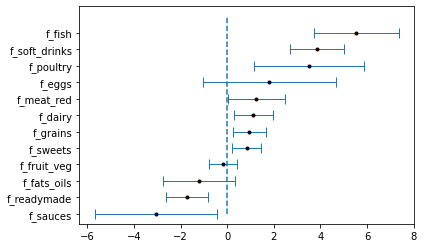

In [434]:
l1, l2, l3, l4 = zip(*sorted(zip(coefficients_1[1:], variables_1[1:], standard_errors_1[1:], p_values_1[1:])))

#fancy plotting

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')
plt.yticks(range(len(l2)),l2);